In [1]:
import pandas as pd
import os
from random import choices
import numpy as np
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score
from tqdm.notebook import tqdm
from src.utils import download_table, get_wandb_summaries
from src.data.utils import download_wandb_table
import wandb
from pprint import pprint
import matplotlib.pyplot as plt
import json
import re
import seaborn as sns

import matplotlib.patches as mpatches
from src.data.hierarchical_bootstrapping import hierarchical_bootstrapping
sns.color_palette

colors = sns.color_palette().as_hex()
print(colors)

['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']


In [2]:
api = wandb.Api()

def search_experiments(model="CNNToTransformerClassifier", task="PredictFluPos", notes="hourly temporal split", _n_runs=5):
    """
    returns experiments ids that match a given a model name, task, and notes. Should return one entry per run (i.e. 5)
    """
    query = api.runs(
                     
            path="bdata/ICML-2023-Flu-Dataset",
#             path="safranchik/mobs",
            filters={"summary_metrics.model": model, "summary_metrics.task": task, "notes": notes},
            order="+summary_metrics.pl_seed"
    )
    if len(query) != 5:
        print("{}-{} with notes \"{}\" has length {}".format(model, task, notes, len(query)))

    return query


wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


  0%|          | 0/10 [00:00<?, ?it/s]

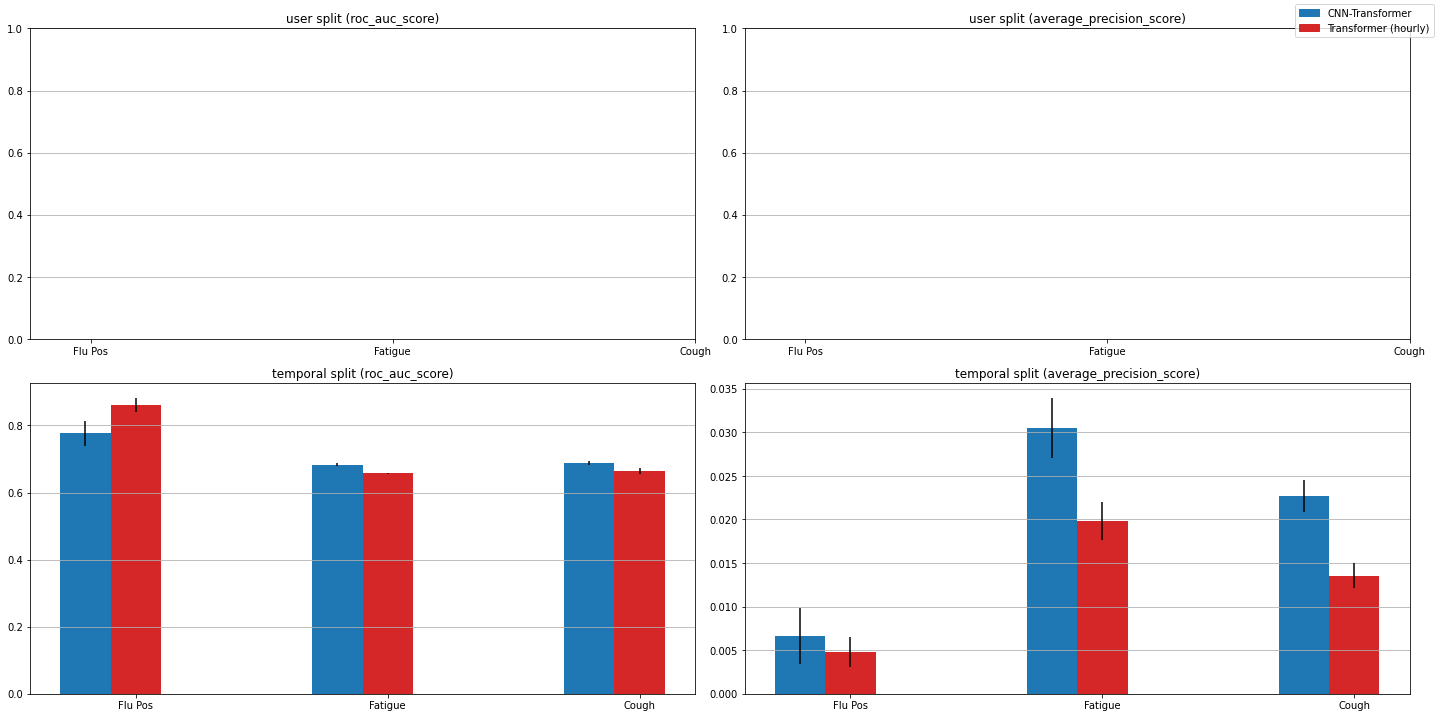

In [3]:
metrics = [roc_auc_score, average_precision_score]

# format: model name, notes, label, color
models = [
            ("CNNToTransformerClassifier", "temporal split", "CNN-Transformer", colors[0]),
#             ("CNNToTransformerClassifier", "user split", "CNN-Transformer", colors[0]),
          
#             ("CNNClassifier", "temporal split", "CNN", colors[1]),
#             ("CNNClassifier", "user split", "CNN", colors[1]),
#             ("CNNClassifier", "hourly temporal split", "CNN (hourly)", colors[2]),
#             ("CNNClassifier", "hourly user split", "CNN (hourly)", colors[2]),
          
            ("TransformerClassifier", "hourly temporal split", "Transformer (hourly)", colors[3]),
#             ("TransformerClassifier", "hourly user split", "Transformer (hourly)", colors[3]),          
          
#             ("XGBoostClassifier", "daily temporal split", "XGBoost (daily)", colors[4]),
#             ("XGBoostClassifier", "daily user split", "XGBoost (daily)", colors[4])
        ]            

tasks = ["HomekitPredictFluPos", "HomekitPredictFatigue", "HomekitPredictCough"]
task_names = ["Flu Pos", "Fatigue", "Cough"]
assert len(tasks) == len(task_names)

splits = ["user", "temporal"]


fig, ax = plt.subplots(2, 2)
fig.set_size_inches(20, 10)

# width of bar charts
width = 0.2

def get_prediction_tables(run_ids):
    tables = []
    for run_id in run_ids:
        try:
#         tables.append(download_wandb_table(run_id.id, table_name="test_predictions", entity="safranchik/bdata", project="ICML-2023-Flu-Dataset"))
            # TODO: pull runs from the bdata/Homekit project 
            tables.append(download_wandb_table(run_id.id, table_name="test_predictions", entity="safranchik", project="mobs"))    
        except:
            continue
    return tables


# download_wandb_table(run_id.id, table_name="test_predictions", entity="bdata", project="ICML-2023-Flu-Dataset/runs")


data = {"temporal": {"roc_auc_score": {}, "average_precision_score": {}},
        "user": {"roc_auc_score": {}, "average_precision_score": {}}}

""" fills out the nested data dictionary """
for j, task in enumerate(tasks):
    for k, (model, note, label, _) in enumerate(models):

        split = "temporal" if "temporal" in note else "user"
        
        run_ids = search_experiments(model, task, note)
        tables = get_prediction_tables(run_ids)

        if not isinstance(tables, float) and not len(tables):
            continue
            
        # TODO: change model bootstraps to 40 and data bootstraps to 10
        # 40 model bootstraps lets us discard the bottom and top outliers to obtain a 95% CI
        bootstraps = hierarchical_bootstrapping(tables, num_bootstraps=10, metrics=metrics)
            
        for l, metric in enumerate(metrics):

            bootstraps_list = bootstraps[metric.__name__]
            metric_mean = np.mean(bootstraps_list)
            metric_err = np.abs(np.percentile(bootstraps_list, (0.975, 0.025)) - metric_mean)

            model_name = model + "_({})".format(note)
            if model_name not in data[split][metric.__name__]:
                data[split][metric.__name__][model_name] = {t: (0,(0,0)) for t in tasks}
                
            data[split][metric.__name__][model_name][task] = (metric_mean, metric_err)
         
""" plots the nested data dictionary """
for i, split in enumerate(splits):
    for l, metric in enumerate(metrics):
        
        ticks = [j + (len(tasks)-1) * width / 2 for j in range(len(tasks))]

        ax[i, l].set_xticks(ticks=ticks, labels=task_names)
        ax[i, l].set_title("{} split ({})".format(split, metric.__name__))
        ax[i, l].grid(axis='y', which="both")

        for k, (model, note, label, color) in enumerate(models):
            model_name = model + "_({})".format(note)

            if model_name in data[split][metric.__name__]:
                
                task_scores = [data[split][metric.__name__][model_name][t][0] for t in tasks]

                lower_err = [data[split][metric.__name__][model_name][t][1][0] for t in tasks]
                upper_err = [data[split][metric.__name__][model_name][t][1][1] for t in tasks]

                x = np.arange(len(tasks)) + k * width
                ax[i, l].bar(x=x, height=task_scores, width=width, yerr=(upper_err, lower_err), color=color)

            
fig.tight_layout()

handles = [mpatches.Patch(label=m[0], color=m[-1]) for m in models]

labels = [m[2] for m in models]

fig.legend(handles, labels)

fig_name = "big_bar_plot.pdf"

fig.savefig(fig_name, bbox_inches='tight', format="pdf")